In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time
# check that I have cpu for train or not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# same pattern when I restart the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

d:\AIT_lecture\NLP\pythonNLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.__version__

'2.1.1+cpu'

In [4]:
torchtext.__version__

'0.16.1+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
import datasets

# Processed TALPCo dataset
dataset= datasets.load_dataset('khinhlaing/myn-eng-dataset')

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'my'],
        num_rows: 8973
    })
    validation: Dataset({
        features: ['en', 'my'],
        num_rows: 499
    })
    test: Dataset({
        features: ['en', 'my'],
        num_rows: 499
    })
})

## 2. EDA - simple investigation

In [7]:
train = [(row['en'], row['my']) for row in dataset['train']]

In [8]:
test = [(row['en'], row['my']) for row in dataset['test']]

In [9]:
val = [(row['en'], row['my']) for row in dataset['validation']]

In [10]:
#let's take a look at one example of train
sample = train[3]
sample

("I still wear dresses when I'm working at home because I feel fancier.",
 'အိမ်မှာ အလုပ်လုပ်ရင်လည်း အင်္ကျီလဲဖြစ်တယ် ပိုပြီးတော့ အာရုံလာလို့လေ။')

In [11]:
train_size = len(list(iter(train)))
train_size

8973

In [12]:
val_size = len(list(iter(val)))
val_size

499

In [13]:
test_size = len(list(iter(test)))
test_size

499

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [14]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [15]:
# # Burmese word tokenizer
# import pyidaungsu as pds

# def pds_tokenizer(sentence):
#     return pds.tokenize(sentence, form="word")

In [17]:
# Myanmar language custom tokenization
"""

This code is updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
Ye Kyaw Thu, LST, NECTEC, Thailand updated followings:
-- added recursion limit
-- changed P_unigram and P_bigram as module level global variable
-- using binary ngram dictionary
--  set N value of this: "def __init__(self, datafile=None, unigram=True, N=102490):"
-- Last Updated: 5 Sept 2021

# References:
- Python implementation of Viterbi algorithm for word segmentation: 
- Updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
- A clean-up of this: http://norvig.com/ngrams/ch14.pdf
- For recursion limit: https://www.geeksforgeeks.org/python-handling-recursion-limit/
- A. Viterbi, "Error bounds for convolutional codes and an asymptotically optimum decoding algorithm," in IEEE Transactions on Information Theory, vol. 13, no. 2, pp. 260-269, April 1967, doi: 10.1109/TIT.1967.1054010.

"""

import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

uni_dict_bin = 'unigram-word.bin'
bi_dict_bin = 'bigram-word.bin'                

def read_dict (fileDICT):
    try:
        with open(fileDICT, 'rb') as input_file:
            dictionary = pickle.load(input_file)
            input_file.close()
    except FileNotFoundError:
        print('Dictionary file', fileDICT, ' not found!')
    return dictionary

class ProbDist(dict):
    ### Probability distribution estimated from unigram/bigram data
    def __init__(self, datafile=None, unigram=True, N=102490):
    #def __init__(self, datafile=None, unigram=True, N=1024908267229):
    #def __init__(self, datafile=None, unigram=True, N=8199266137832):
        #data = {}
        data = read_dict(datafile)
        for k, c in data.items():
            self[k] = self.get(k, 0) + c

        if unigram:
            self.unknownprob = lambda k, N: 10 / (N*10**len(k))    # avoid unknown long word
        else:
            self.unknownprob = lambda k, N: 1 / N

        self.N = N

    def __call__(self, key):
        if key in self:
            return self[key]/self.N
        else:
            return self.unknownprob(key, self.N)
        

P_unigram = ProbDist(uni_dict_bin, True)
P_bigram = ProbDist(bi_dict_bin, False)


def conditionalProb(word_curr, word_prev):
    ### Conditional probability of current word given the previous word.
    try:
        return P_bigram[word_prev + ' ' + word_curr]/P_unigram[word_prev]
    except KeyError:
        return P_unigram(word_curr)


@functools.lru_cache(maxsize=2**10)
#maxlen=20
def viterbi(text, prev='<S>', maxlen=20):
    if not text:
        return 0.0, []
    
    #print("text: ", text)
    textlen = min(len(text), maxlen)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(textlen)]

    candidates = []
    #print("clear candidates!  candidates = []")
    for first_word, remain_word in splits:
        #pdb.set_trace()
        first_prob = math.log10(conditionalProb(first_word, prev))
        #print("first_prob of condProb(", first_word, ", ", prev, "): ", first_prob )
        remain_prob, remain_word = viterbi(remain_word, first_word)
        #print("remain_prob: ", remain_prob, ", remain_word: ", remain_word)
        candidates.append((first_prob + remain_prob, [first_word] + remain_word))
        #print("first_prob: ", str(first_prob), ", remain_prob: ", remain_prob, ", [first_word]:", [first_word], ", remain_word: ", remain_word)
        #print("Candidates: ", candidates)
        
    #print("max(candidates): " + str(max(candidates)))
    #print("====================")
    return max(candidates)

In [18]:
def my_tokenizer(text):
    if text is None:
        return []
    wordDelimiter= '|' # assign local variable delimiter

    input      = text[:]
    # text     = corpus['train'][0][TRG_LANGUAGE]
    listString = viterbi(input.replace(" ", "").strip()) # remove space between words and pass to viterbi()
    # print("listString: " + str(listString))
    wordStr    = wordDelimiter.join(listString[1])
    wordClean1 = wordStr.strip()
    wordClean2 = wordClean1.strip(wordDelimiter)    
    wordClean2 = wordClean2.split('|')                
    return wordClean2

In [19]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'my'

In [20]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = my_tokenizer

In [21]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  I still wear dresses when I'm working at home because I feel fancier.
Tokenization:  ['I', 'still', 'wear', 'dresses', 'when', 'I', "'m", 'working', 'at', 'home', 'because', 'I', 'feel', 'fancier', '.']


In [22]:
#example of tokenization of the burmese part
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  အိမ်မှာ အလုပ်လုပ်ရင်လည်း အင်္ကျီလဲဖြစ်တယ် ပိုပြီးတော့ အာရုံလာလို့လေ။
Tokenization:  ['အိမ်', 'မှာ', 'အလုပ်', 'လုပ်', 'ရင်', 'လည်း', 'အင်္ကျီ', 'လဲ', 'ဖြစ်', 'တယ်', 'ပို', 'ပြီး', 'တော့', 'အာရုံ', 'လာ', 'လို့', 'လေ', '။']


A function to tokenize our input.

In [23]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [24]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [25]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [26]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[198, 13, 9, 0, 9]

In [27]:
import pickle

pickle.dump(vocab_transform, open('app/models/vocabs.pkl', 'wb'))

In [28]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[5]

'the'

In [29]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [30]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [31]:
#check unique vocabularies
len(mapping)

6769

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [32]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 128

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [33]:
batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [34]:
for en, _, my in train_loader:
    break

In [35]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Burmese shape: ", my.shape)   # (batch_size, seq len)

English shape:  torch.Size([128, 39])
Burmese shape:  torch.Size([128, 69])


## 5. Design the model



### Encoder Layer

In [36]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attn_type, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_type)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer



$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [38]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, attn_type):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_type = attn_type
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
                
        # Additive attention parameters
        if self.attn_type == 'additive':
            self.W_q = nn.Linear(self.head_dim, self.head_dim)
            self.W_k = nn.Linear(self.head_dim, self.head_dim)
            self.v = nn.Linear(self.head_dim, 1)
        
        # Cosine attention parameter
        if self.attn_type == 'multiplicative':
            self.temperature = nn.Parameter(torch.ones(1))
            
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        # Calculate attention scores
        if self.attn_type == 'general':
            energy = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
            
        elif self.attn_type == 'additive':
            q_trans = self.W_q(Q).unsqueeze(3) # [batch, heads, q_len, 1, dim]
            k_trans = self.W_k(K).unsqueeze(2) # [batch, heads, 1, k_len, dim]
            energy = self.v(torch.tanh(q_trans + k_trans)).squeeze(-1) # Shape: [batch, heads, q_len, k_len]
            
        elif self.attn_type == 'multiplicative':
            Q_norm = Q / (Q.norm(dim=-1, keepdim=True) + 1e-8)
            K_norm = K / (K.norm(dim=-1, keepdim=True) + 1e-8)
            energy = self.temperature * torch.matmul(Q_norm, K_norm.transpose(-2, -1))
            # Q_norm = self.fc_q(Q) / self.scale
            # K_norm = self.fc_k(K)
            # energy = torch.matmul(Q_norm, K_norm.transpose(-2, -1))
            # Multiplicative attention: e_i = s^T W h_i

        else:
            raise ValueError(f"Unknown attention type: {self.attn_type}")
        
        #q = self.W(Q)
        #k = self.U(K)

        # # e = v ( tanh( W(Q) + U(K) ) )
        # energy = self.v(torch.tanh(q + k)) / self.scale
        # #energy = [batch_size, n heads, query len, key len, 1]

        # energy = energy.squeeze(4)
        # #energy = [batch_size, n heads, query len, key len]
                
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [39]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [40]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [41]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, attn_type, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_type)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [42]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [43]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [44]:
def initialize_model(attention_type):
    INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
    OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
    HID_DIM = 256
    ENC_LAYERS = 3
    DEC_LAYERS = 3
    ENC_HEADS = 8
    DEC_HEADS = 8
    ENC_PF_DIM = 512
    DEC_PF_DIM = 512
    ENC_DROPOUT = 0.1
    DEC_DROPOUT = 0.1
    
    enc = Encoder(INPUT_DIM, 
                  HID_DIM, 
                  ENC_LAYERS, 
                  ENC_HEADS, 
                  ENC_PF_DIM, 
                  ENC_DROPOUT, 
                  device,
                  attention_type)
    
    dec = Decoder(OUTPUT_DIM, 
                  HID_DIM, 
                  DEC_LAYERS, 
                  DEC_HEADS, 
                  DEC_PF_DIM, 
                  DEC_DROPOUT, 
                  device,
                  attention_type)
    
    SRC_PAD_IDX = PAD_IDX
    TRG_PAD_IDX = PAD_IDX
    
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    return model

In [45]:
# input_dim   = len(vocab_transform[SRC_LANGUAGE])
# output_dim  = len(vocab_transform[TRG_LANGUAGE])
# hid_dim = 256
# enc_layers = 3
# dec_layers = 3
# enc_heads = 8
# dec_heads = 8
# enc_pf_dim = 512
# dec_pf_dim = 512
# enc_dropout = 0.1
# dec_dropout = 0.1

# SRC_PAD_IDX = PAD_IDX
# TRG_PAD_IDX = PAD_IDX

# enc = Encoder(input_dim, 
#               hid_dim, 
#               enc_layers, 
#               enc_heads, 
#               enc_pf_dim, 
#               enc_dropout, 
#               device)

# dec = Decoder(output_dim, 
#               hid_dim, 
#               dec_layers, 
#               dec_heads, 
#               dec_pf_dim, 
#               enc_dropout, 
#               device)

# model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
# model.apply(initialize_weights)

In [46]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

### General Attention

In [47]:
general_model = initialize_model('general')
    
count_parameters(general_model)

1732864
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1156352
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1156352
  4517
______
8259749


### Multiplicative Attention

In [48]:
multi_model = initialize_model('multiplicative')
    
count_parameters(multi_model)

1732864
128000
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1156352
128000
   256
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1156352
  4517
______
825

### Additive Attention

In [49]:
add_model = initialize_model('additive')
    
count_parameters(add_model)

1732864
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
1156352
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

In [50]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
general_optimizer = optim.Adam(general_model.parameters(), lr=lr)
general_criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

multi_optimizer = optim.Adam(multi_model.parameters(), lr=lr)
multi_criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

add_optimizer = optim.Adam(add_model.parameters(), lr=lr)
add_criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [51]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [52]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [53]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [54]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## General Attention Model Training

In [55]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

gen_save_path = f'app/models/general_model_final.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(general_model, train_loader, general_optimizer, general_criterion, clip, train_loader_length)
    valid_loss = evaluate(general_model, valid_loader, general_criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(general_model.state_dict(), gen_save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 7m 12s
	Train Loss: 5.942 | Train PPL: 380.833
	 Val. Loss: 4.854 |  Val. PPL: 128.221
Epoch: 02 | Time: 7m 38s
	Train Loss: 4.594 | Train PPL:  98.892
	 Val. Loss: 4.306 |  Val. PPL:  74.137
Epoch: 03 | Time: 7m 36s
	Train Loss: 4.099 | Train PPL:  60.270
	 Val. Loss: 4.061 |  Val. PPL:  58.041
Epoch: 04 | Time: 9m 16s
	Train Loss: 3.758 | Train PPL:  42.864
	 Val. Loss: 3.926 |  Val. PPL:  50.680
Epoch: 05 | Time: 14m 4s
	Train Loss: 3.488 | Train PPL:  32.706
	 Val. Loss: 3.829 |  Val. PPL:  46.007


Text(0, 0.5, 'loss')

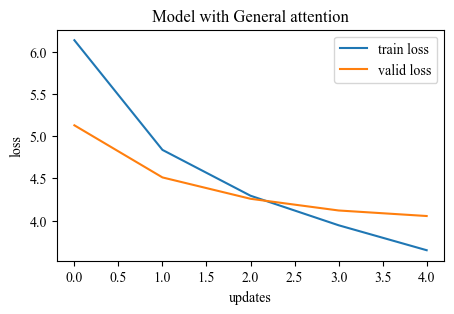

In [199]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_title('Model with General attention')
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [57]:
general_model.load_state_dict(torch.load(gen_save_path))
test_loss = evaluate(general_model, test_loader, general_criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.828 | Test PPL:  45.953 |


## Multiplicative Attention Model Training

In [97]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

multi_save_path = f'app/models/multi_model_v4.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(multi_model, train_loader, multi_optimizer, multi_criterion, clip, train_loader_length)
    valid_loss = evaluate(multi_model, valid_loader, multi_criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(multi_model.state_dict(), multi_save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 6m 56s
	Train Loss: 6.120 | Train PPL: 454.785
	 Val. Loss: 5.108 |  Val. PPL: 165.408
Epoch: 02 | Time: 6m 57s
	Train Loss: 4.823 | Train PPL: 124.347
	 Val. Loss: 4.514 |  Val. PPL:  91.297
Epoch: 03 | Time: 6m 53s
	Train Loss: 4.291 | Train PPL:  73.053
	 Val. Loss: 4.261 |  Val. PPL:  70.914
Epoch: 04 | Time: 11m 23s
	Train Loss: 3.934 | Train PPL:  51.103
	 Val. Loss: 4.103 |  Val. PPL:  60.525
Epoch: 05 | Time: 7m 11s
	Train Loss: 3.654 | Train PPL:  38.622
	 Val. Loss: 4.036 |  Val. PPL:  56.573


Text(0, 0.5, 'loss')

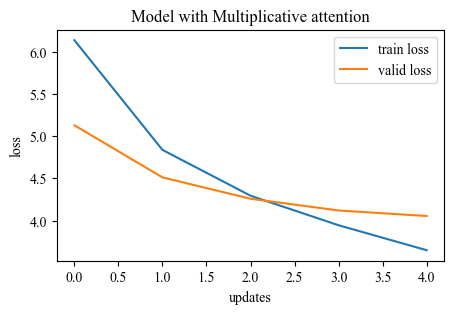

In [197]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_title('Model with Multiplicative attention')
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [145]:
multi_model.load_state_dict(torch.load(multi_save_path))
test_loss = evaluate(multi_model, test_loader, multi_criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.584 | Test PPL:  36.017 |


## Additive Attention Model Training

In [98]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

add_save_path = f'app/models/add_model_v4.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(add_model, train_loader, add_optimizer, add_criterion, clip, train_loader_length)
    valid_loss = evaluate(add_model, valid_loader, add_criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(add_model.state_dict(), add_save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 10m 4s
	Train Loss: 6.138 | Train PPL: 463.205
	 Val. Loss: 5.129 |  Val. PPL: 168.846
Epoch: 02 | Time: 10m 31s
	Train Loss: 4.837 | Train PPL: 126.143
	 Val. Loss: 4.511 |  Val. PPL:  91.005
Epoch: 03 | Time: 18m 35s
	Train Loss: 4.294 | Train PPL:  73.248
	 Val. Loss: 4.258 |  Val. PPL:  70.640
Epoch: 04 | Time: 20m 58s
	Train Loss: 3.944 | Train PPL:  51.602
	 Val. Loss: 4.119 |  Val. PPL:  61.492
Epoch: 05 | Time: 10m 19s
	Train Loss: 3.648 | Train PPL:  38.379
	 Val. Loss: 4.053 |  Val. PPL:  57.583


Text(0, 0.5, 'loss')

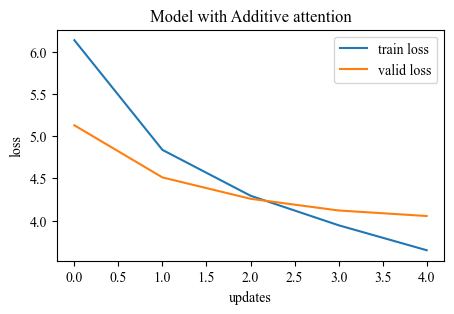

In [198]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_title('Model with Additive attention')
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [101]:
add_model.load_state_dict(torch.load(add_save_path))
test_loss = evaluate(add_model, test_loader, add_criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.028 | Test PPL:  56.121 |


In [193]:
# function for calculate the accuracy of model based on correction that model need to predict same with target
def model_accuracy(model, loader,loader_length):
    
    model.eval()
    count = 0
        
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        

            output, _ = model(src, trg[:,:-1])
               
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            output = output.argmax(1)
            #output = [batch size * trg len - 1]
            #trg = [batch size * trg len - 1]                       

            if output.tolist() == trg.tolist():
                count+=1
            else:
                continue         
       
    return (count / loader_length)*100

In [194]:
general_acc=model_accuracy(general_model,test_loader,test_loader_length)
general_acc

0.0

In [195]:
multi_acc=model_accuracy(multi_model,test_loader,test_loader_length)
multi_acc

0.0

In [196]:
add_acc=model_accuracy(add_model,test_loader,test_loader_length)
add_acc

0.0

## 7. Testing on sample

In [102]:
text_text = dataset['train'][44]
src_text = text_transform[SRC_LANGUAGE](text_text['en']).to(device).reshape(1, -1)
trg_text = text_transform[TRG_LANGUAGE](text_text['my']).to(device).reshape(1, -1)

In [104]:
text_text['en'], text_text['my']

("The FBI was interested in the instructor's reaction to a video of two kittens playing with a ball.",
 'ဘောလုံး နှင့်အတူ ကစားနေသော ကြောင်လေး နှစ်ကောင် ရဲ့ ဗီဒီယို အပေါ် နည်းပြဆရာ ရဲ့ တုံ့ပြန်မှု ကို FBI က စိတ်ဝင်စားခဲ့သည်။')

In [117]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [140]:
text_text = dataset['train'][43]
text_text

{'en': 'Guns and other forms of weaponry fall into this category.',
 'my': 'သေနတ် နှင့် အမျိုးမျိုးသော လက်နက်များသည် ဤအမျိုးအစားတွင် ပါဝင်သည်။'}

In [141]:
text_text['en']

'Guns and other forms of weaponry fall into this category.'

In [142]:
text_text['my']

'သေနတ် နှင့် အမျိုးမျိုးသော လက်နက်များသည် ဤအမျိုးအစားတွင် ပါဝင်သည်။'

In [143]:
src_text = text_transform[SRC_LANGUAGE](text_text['en']).to(device)
src_text

tensor([   0, 3964,   10,   92, 1476,    8, 6741, 1647,  129,   43, 2139,    4,
           1])

In [144]:
trg_text = text_transform[TRG_LANGUAGE](text_text['my']).to(device)
trg_text

tensor([  0, 497,  29, 537,  16, 764,   7,   5, 110, 395,  22,  14,  67,   5,
          4,   1])

In [145]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [146]:
trg_text = trg_text.reshape(1, -1)

In [147]:
src_text.shape, trg_text.shape

(torch.Size([1, 13]), torch.Size([1, 16]))

In [148]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [149]:
general_model.load_state_dict(torch.load(gen_save_path))

general_model.eval()
with torch.no_grad():
    g_output, g_attentions = general_model(src_text, trg_text) #turn off teacher forcing

In [150]:
g_output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 16, 4517])

Since batch size is 1, we just take off that dimension

In [151]:
g_output = g_output.squeeze(0)

In [152]:
g_output.shape

torch.Size([16, 4517])

We shall remove the first token since it's zeroes anyway

In [153]:
g_output = g_output[1:]
g_output.shape #trg_len, trg_output_dim

torch.Size([15, 4517])

In [154]:
g_output_max = g_output.argmax(1) #returns max indices

In [155]:
g_output_max

tensor([29,  9, 16, 79,  7,  5,  4, 29, 29, 14,  5,  5,  4,  3, 29])

Get the mapping of the target language

In [156]:
g_mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [157]:
for token in g_output_max:
    print(g_mapping[token.item()])

နှင့်
မ
သော
ကြောင့်
များ
သည်
။
နှင့်
နှင့်
ပါ
သည်
သည်
။
<eos>
နှင့်


Let's display the attentions to understand how the source text links with the generated text

In [158]:
g_attentions.shape

torch.Size([1, 8, 16, 13])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [159]:
g_attention = g_attentions[0, 0, :, :]
g_attention.shape

torch.Size([16, 13])

In [160]:
g_src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](text_text['en']) + ['<eos>']
g_src_tokens

['<sos>',
 'Guns',
 'and',
 'other',
 'forms',
 'of',
 'weaponry',
 'fall',
 'into',
 'this',
 'category',
 '.',
 '<eos>']

In [161]:
g_trg_tokens = ['<sos>'] + [g_mapping[token.item()] for token in g_output_max]
g_trg_tokens

['<sos>',
 'နှင့်',
 'မ',
 'သော',
 'ကြောင့်',
 'များ',
 'သည်',
 '။',
 'နှင့်',
 'နှင့်',
 'ပါ',
 'သည်',
 'သည်',
 '။',
 '<eos>',
 'နှင့်']

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch

def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    if isinstance(attention, torch.Tensor):
        attention = attention.detach().cpu().numpy()  # Ensure it's a NumPy array

    # Handle multi-head attention (average across heads)
    if attention.ndim == 3:  # (num_heads, target_seq_len, source_seq_len)
        attention = attention.mean(axis=0)  # Average over all heads

    cax = ax.matshow(attention, cmap='bone')
    
    ax.tick_params(labelsize=10)

    y_ticks = [''] + translation
    x_ticks = [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks, fontdict={'fontname': 'Myanmar Text'})

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.colorbar(cax)
    plt.show()
    plt.close()

# Example Usage
src_tokens = g_src_tokens  # Tokenized input
trg_tokens = g_trg_tokens  # Tokenized output

with torch.no_grad():
    output = general_model(src_tokens, trg_tokens)  # Forward pass

    # Extract attention weights (modify based on model implementation)
    if hasattr(general_model, "get_attention_weights"):
        attention_weights = general_model.get_attention_weights()  # Example method
    else:
        raise ValueError("The model does not provide an attention extraction method.")

# Call display function with extracted attention weights
display_attention(src_tokens, trg_tokens, attention_weights)


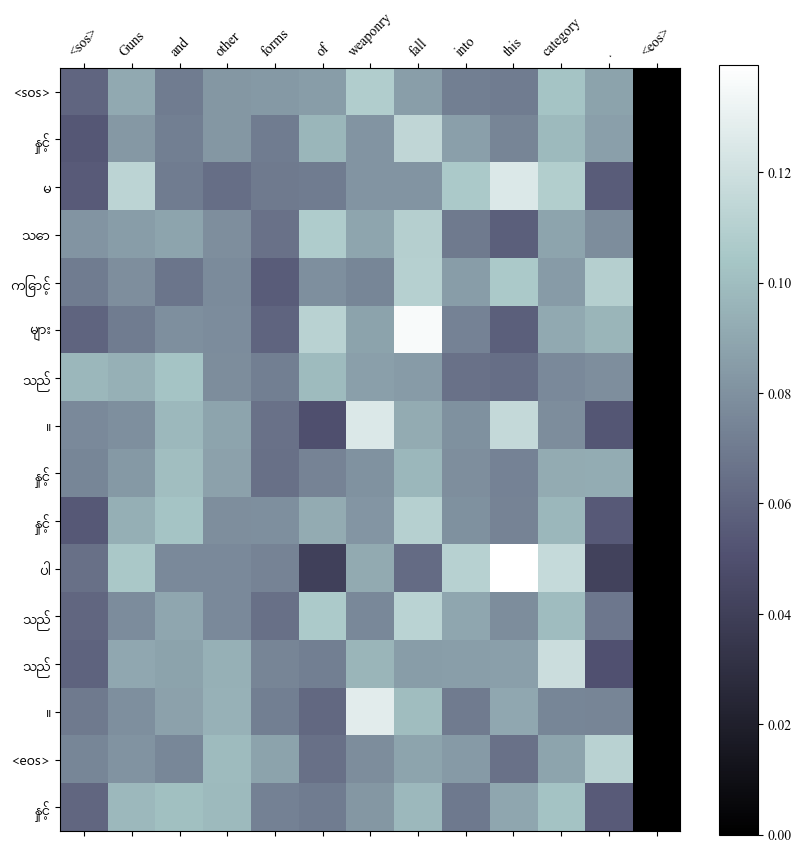

In [164]:
display_attention(g_src_tokens, g_trg_tokens, g_attention)

### Multiplicative Attention Testing

In [165]:
multi_model.load_state_dict(torch.load(multi_save_path))

multi_model.eval()
with torch.no_grad():
    m_output, m_attentions = general_model(src_text, trg_text) #turn off teacher forcing

In [166]:
m_output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 16, 4517])

Since batch size is 1, we just take off that dimension

In [167]:
m_output = m_output.squeeze(0)

In [168]:
m_output.shape

torch.Size([16, 4517])

We shall remove the first token since it's zeroes anyway

In [169]:
m_output = m_output[1:]
m_output.shape #trg_len, trg_output_dim

torch.Size([15, 4517])

Then we just take the top token with highest probabilities

In [170]:
m_output_max = m_output.argmax(1) #returns max indices

In [171]:
m_output_max

tensor([29,  9, 16, 79,  7,  5,  4, 29, 29, 14,  5,  5,  4,  3, 29])

Get the mapping of the target language

In [172]:
m_mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [173]:
for token in m_output_max:
    print(m_mapping[token.item()])

နှင့်
မ
သော
ကြောင့်
များ
သည်
။
နှင့်
နှင့်
ပါ
သည်
သည်
။
<eos>
နှင့်


Let's display the attentions to understand how the source text links with the generated text

In [174]:
m_attentions.shape

torch.Size([1, 8, 16, 13])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [175]:
m_attentions = m_attentions[0, 0, :, :]
m_attentions.shape

torch.Size([16, 13])

In [176]:
m_src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](text_text['en']) + ['<eos>']
m_src_tokens

['<sos>',
 'Guns',
 'and',
 'other',
 'forms',
 'of',
 'weaponry',
 'fall',
 'into',
 'this',
 'category',
 '.',
 '<eos>']

In [177]:
m_trg_tokens = ['<sos>'] + [m_mapping[token.item()] for token in m_output_max]
m_trg_tokens

['<sos>',
 'နှင့်',
 'မ',
 'သော',
 'ကြောင့်',
 'များ',
 'သည်',
 '။',
 'နှင့်',
 'နှင့်',
 'ပါ',
 'သည်',
 'သည်',
 '။',
 '<eos>',
 'နှင့်']

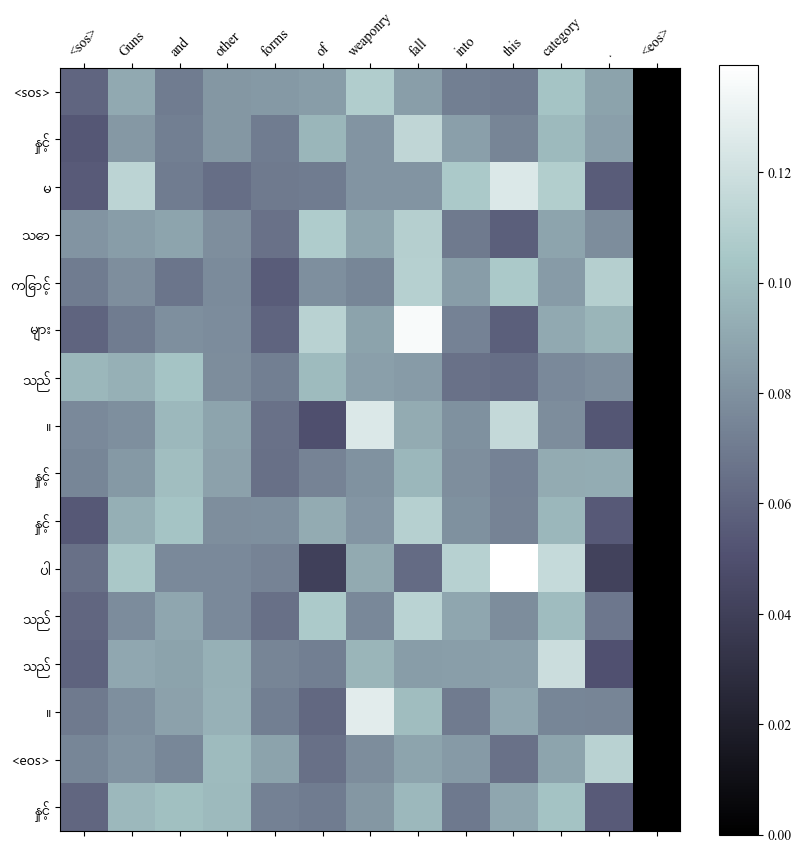

In [178]:
display_attention(m_src_tokens, m_trg_tokens, m_attentions)

### Additive Attention Testing

In [179]:
add_model.load_state_dict(torch.load(add_save_path))

add_model.eval()
with torch.no_grad():
    a_output, a_attentions = add_model(src_text, trg_text) #turn off teacher forcing

In [180]:
a_output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 16, 4517])

Since batch size is 1, we just take off that dimension

In [181]:
a_output = a_output.squeeze(0)

In [182]:
a_output.shape

torch.Size([16, 4517])

We shall remove the first token since it's zeroes anyway

In [183]:
a_output = a_output[1:]
a_output.shape #trg_len, trg_output_dim

torch.Size([15, 4517])

Then we just take the top token with highest probabilities

In [184]:
a_output_max = a_output.argmax(1) #returns max indices

In [185]:
a_output_max

tensor([  7, 106,  16,  93,   7,   5,  81,  93,   7,  12,   5,   5,   4,   4,
          7])

Get the mapping of the target language

In [186]:
a_mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [187]:
for token in a_output_max:
    print(a_mapping[token.item()])

များ
ပတ်သက်
သော
အရာ
များ
သည်
၎င်း
အရာ
များ
ရှိ
သည်
သည်
။
။
များ


Let's display the attentions to understand how the source text links with the generated text

In [188]:
a_attentions.shape

torch.Size([1, 8, 16, 13])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [189]:
a_attentions = a_attentions[0, 0, :, :]
a_attentions.shape

torch.Size([16, 13])

In [190]:
a_src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](text_text['en']) + ['<eos>']
a_src_tokens

['<sos>',
 'Guns',
 'and',
 'other',
 'forms',
 'of',
 'weaponry',
 'fall',
 'into',
 'this',
 'category',
 '.',
 '<eos>']

In [191]:
a_trg_tokens = ['<sos>'] + [a_mapping[token.item()] for token in a_output_max]
a_trg_tokens

['<sos>',
 'များ',
 'ပတ်သက်',
 'သော',
 'အရာ',
 'များ',
 'သည်',
 '၎င်း',
 'အရာ',
 'များ',
 'ရှိ',
 'သည်',
 'သည်',
 '။',
 '။',
 'များ']

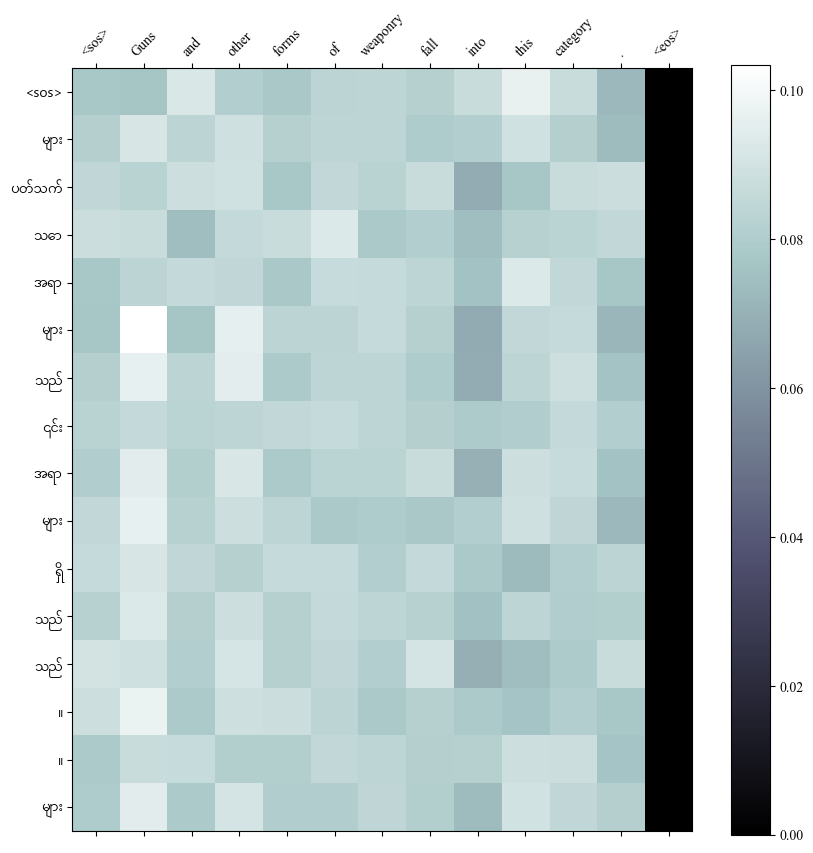

In [192]:
display_attention(a_src_tokens, a_trg_tokens, a_attentions)